---
title: Positional encodings
description: "test test test"
image: images/positional_encoding.png
toc: true
---

## What are positional encodings?
A positional encoding (PE) is additional information about **where** each token appears in a sequence.
They are typically added to input tokens before feeding them into transformer layers, so the model can distinguish sentences like "The cat chased the dog" and "The dog chased the cat".

The [Transformer](transformer.ipynb)

> Positional encoding describes the location or position of an entity in a sequence so that each position is assigned a unique representation. 

> In languages, the order of the words and their position in a sentence really matters. The meaning of the entire sentence can change if the words are re-ordered. When implementing NLP solutions, recurrent neural networks have an inbuilt mechanism that deals with the order of sequences. The transformer model, however, does not use recurrence or convolution and treats each data point as independent of the other. Hence, positional information is added to the model explicitly to retain the information regarding the order of words in a sentence. Positional encoding is the scheme through which the knowledge of the order of objects in a sequence is maintained.

![](images/positional_encodings.png)
![](images/positional_encoding.png)

## Why do you need positional encodings?
"The dog chased the cat"

> There are many reasons why a single number, such as the index value, is not used to represent an item’s position in transformer models. For long sequences, the indices can grow large in magnitude. If you normalize the index value to lie between 0 and 1, it can create problems for variable length sequences as they would be normalized differently.

> Let's  define some desirable properties that will make the optimization process as easy as possible.
- Values should be between 0 and 1
- Unique encoding for each position (across sequences): Each position needs a unique encoding that remains consistent regardless of sequence length. A token at position 5 should have the same encoding whether the current sequence is of length 10 or 10,000.
- Linear relation between two encoded positions: The relationship between positions should be mathematically simple. If we know the encoding for position $p$, it should be straightforward to compute the encoding for position $p+k$, making it easier for the model to learn positional patterns. If you think about how we represent numbers on a number line, it's easy to understand that 5 is 2 steps away from 3. The same intuitive relationship should exist in our encodings.
- Generalizes to longer sequences than those encountered during training: To increase our models' utility in the real world, they should generalize outside their training distribution. Therefore, our encoding scheme needs to be adaptable enough to handle unexpected input lengths, without violating any of our other desirable properties.
- Generated by a deterministic process the model can learn: It would be ideal if our positional encodings could be drawn from a deterministic process. This should allow the model to learn the mechanism behind our encoding scheme efficiently.
- Extensible to multiple dimensions: With multimodal models becoming the norm, it is crucial that our positional encoding scheme can naturally extend from 1D to nD. This will allow models to consume data like images or brain scans, which are 2D and 4D respectively.

<!-- 
## What is the difference between a positional encoding and a position embedding
-->
While the terms "positional encoding" and "position embedding" are often used interchangeably, they are not exactly the same.
"Positional encoding" in the [Transformer paper](https://arxiv.org/abs/1706.03762)
"Position embeddings" in the [BERT paper](https://arxiv.org/abs/1810.04805)

An embedding is a learned positional encoding (learnable parameters)
The encoding is a static mathematical function that maps 


Most papers and discussions use "positional encoding" as the umbrella term.

## Absolute positioning
Absolute position encodings encode the exact position in the sequence (position 1, 2, 3, etc.)

Each position has a fixed representation

Example: "cat" at position 1 always gets the same positional encoding

<!-- ### Naive Integer encoding, Motivation -->
The first approach that may jump to mind is simply to add the integer value of the token position to each component of the token embedding, with values ranging from 0→L where L is the length of our current sequence.

This doesn't work well because:
- Large integers dominate the word embeddings
- No bounds on values (position 1000 vs position 1)
- Poor mathematical properties for learning


### Sinusoidal encodings
 (original Transformer)

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model,  max_seq_len=5000, dropout=0.1,):
        """
        Args:
            d_model: dimension of embeddings
            dropout: dropout rate, the original paper uses 0.1
            max_seq_len: maximum sequence length
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1)

        # Create a div term for the denominator
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        # Apply sin to even indices (0, 2, 4, ...)
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cos to odd indices (1, 3, 5, ...)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension
        pe = pe.unsqueeze(0)

        # Register as buffer (saved with model, not trained)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x shape : [batch_size, seq_len, d_model]
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len].requires_grad_(False) # TODO: what does this "requires_grad_(False)" do?
        return self.dropout(x)

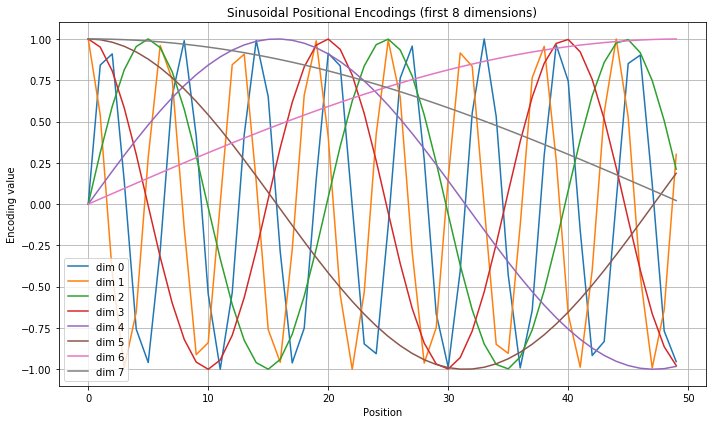

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_sinusoidal_encoding(seq_len, d_model):
    """
    Compute sinusoidal positional encodings as in the original Transformer paper.

    Args:
        seq_len (int): Length of the sequence (number of positions).
        d_model (int): Embedding dimension.

    Returns:
        np.ndarray: (seq_len, d_model) matrix of positional encodings.
    """
    position = np.arange(seq_len)[:, np.newaxis]  # (seq_len, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe



In [ ]:
#| echo: false
#| output: true
"""import altair as alt
import pandas as pd

def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)"""

In [ ]:

# Parameters for visualization
seq_len = 50      # Number of positions (tokens)
d_model = 16      # Embedding dimension

# Compute positional encodings
pe = get_sinusoidal_encoding(seq_len, d_model)

# Plot several dimensions of the positional encoding for the first 50 positions
plt.figure(figsize=(10, 6))
for i in range(min(8, d_model)):
    plt.plot(pe[:, i], label=f"dim {i}")
plt.title("Sinusoidal Positional Encodings (first 8 dimensions)")
plt.xlabel("Position")
plt.ylabel("Encoding value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

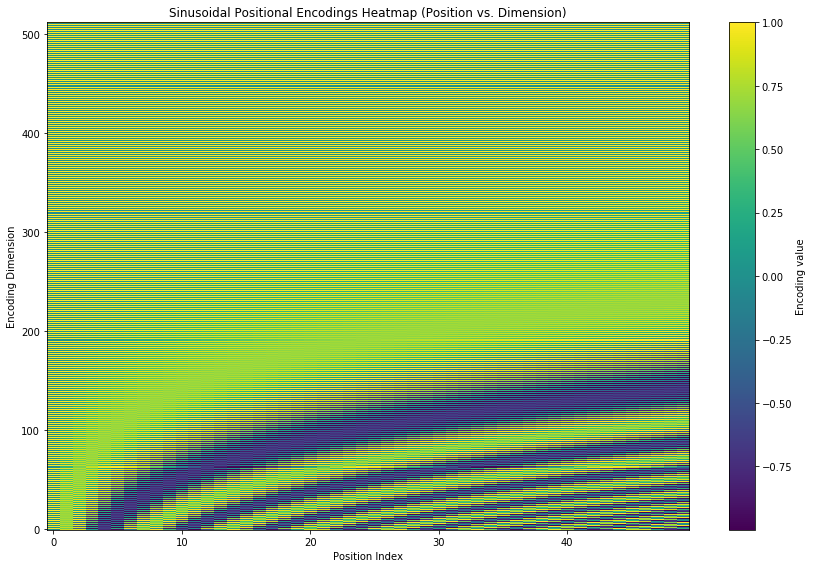

In [6]:
# Increase embedding dimension to 512
d_model = 512
pe = get_sinusoidal_encoding(seq_len, d_model)

plt.figure(figsize=(12, 8))
# x-axis is position, y-axis is dimension
plt.imshow(pe.T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label="Encoding value")
plt.xlabel("Position Index")
plt.ylabel("Encoding Dimension")
plt.title("Sinusoidal Positional Encodings Heatmap (Position vs. Dimension)")
plt.tight_layout()
plt.show()


### Learned absolute embeddings
Used in: BERT; GPT2-3

learned positional embeddings [(cite)](https://arxiv.org/pdf/1705.03122.pdf) 

While you could alternatively learn positional embeddings as trainable parameters,

The sinusoidal approach offers key advantages: 
—it requires no additional parameters, 
- can handle sequences longer than those seen during training, /allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

- and provides interpretable positional relationships that the attention mechanism can leverage.

In [ ]:
import torch.nn as nn

class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
    
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device)
        return x + self.pos_embedding(positions)

### Rotary Position Embedding (RoPE)
Paper: https://arxiv.org/abs/2104.09864

RoPE has become particularly popular in recent large language models because it handles variable sequence lengths well and maintains relative distance information effectively.

Used in Llama 3.2 (to do fact check), most recent LLMs
Gemma 2 (https://arxiv.org/html/2408.00118v1)

In [ ]:
import torch

def rope_encoding(q, k, positions, dim):
    """Apply RoPE to query and key tensors"""
    def rotate_half(x):
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat((-x2, x1), dim=-1)
    
    # Create rotation frequencies
    inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
    
    # Compute rotation angles
    freqs = torch.outer(positions.float(), inv_freq)
    freqs = torch.cat([freqs, freqs], dim=-1)
    
    cos_freq = freqs.cos()
    sin_freq = freqs.sin()
    
    # Apply rotation
    q_rot = q * cos_freq + rotate_half(q) * sin_freq
    k_rot = k * cos_freq + rotate_half(k) * sin_freq
    
    return q_rot, k_rot

<!-- ## Long-context -->

RoPE's main issue with long contexts is frequency collision. As sequences get longer, different positions start having nearly identical rotational encodings, making them indistinguishable.

This happens because:
- RoPE uses fixed frequencies that repeat in cycles
- Very long sequences exceed these cycle lengths
- The model can't tell distant positions apart

Solutions include:
- Frequency scaling (reducing base frequency from 10k to 1M+)
- Position interpolation
- ALiBi (linear attention biases instead of rotational encoding)
- Hybrid approaches combining multiple methods

That's why newer long-context models often modify RoPE or use alternative position encodings.RetryClaude can make mistakes. Please double-check responses.


## Relative positioning
Relative position encodings the distance between tokens

Focus on relationships rather than exact positions

Example: "cat" and "dog" are 2 positions apart, regardless of whether they're at positions (1,3) or (5,7)

<!--
### Relative position embeddings (T5, DeBERTa)


### ALiBi (Attention with Linear Biases)


### Relative positional encodings (Shaw et al.)
...
-->


<!-- ## What is the difference between absolute and relative position embeddings? -->

Many models use relative position embeddings instead of absolute position embeddings because they often work better for longer sequences and generalize better to unseen sequence lengths.

![](images/absolute_relative_positional_encoding.png)

## Summary

| Sinusoidal positional encoding | Learned positional encodings |
| -- | -- |
| No additional parameters | Adds parameters to train |
| Can extrapolate to longer sequence | Limited to max_seq_len seen in training |
| Mathematical interpretability | Potentially more flexible |
| Used in original transformer paper | Common in modern implementations |